# Fit ZP Lee's spectra

In [1]:
# imports
from importlib import reload
from importlib.resources import files
import os
import numpy as np

from scipy.optimize import curve_fit

import pandas
import seaborn as sns
from matplotlib import pyplot as plt

from scipy.interpolate import interp1d

from ocpy.hydrolight import loisel23
from ocpy.utils import plotting as oc_plotting
from ocpy.satellites import pace as sat_pace

from bing.models import anw as boring_anw
from bing.models import bbnw as boring_bbnw
from bing.models import utils as model_utils
from bing.models import functions
from bing import inference as big_inf
from bing import rt as big_rt
from bing import chisq_fit


In [2]:
%matplotlib ipympl

# Load

## Load up Loisel+2023 Hydrolight dataset

## Using the full run (inelastic scattering) at Zenith

In [3]:
ds = loisel23.load_ds(4,0)

In [9]:
l23_wave = ds.Lambda.data
l23_Rrs = ds.Rrs.data
all_a = ds.a.data
all_bb = ds.bb.data
all_bbnw = ds.bbnw.data
all_adg = ds.ag.data + ds.ad.data
all_ad = ds.ad.data
all_ag = ds.ag.data
all_aph = ds.aph.data
all_anw = ds.anw.data

In [5]:
aw = all_a[0] - all_anw[0]

In [6]:
all_anw.shape

(3320, 81)

## Lee $a_{\rm ph}$

In [20]:
lee_file = 'ZP_Lee/aph_samples.csv'
df_lee = pandas.read_csv(lee_file)
df_lee.head()

,wave,aph_1,aph_2
0,400,0.383277,0.118626
1,405,0.394072,0.122840
2,410,0.428293,0.132003
3,415,0.450018,0.136293
4,420,0.458255,0.137845


## Plot em

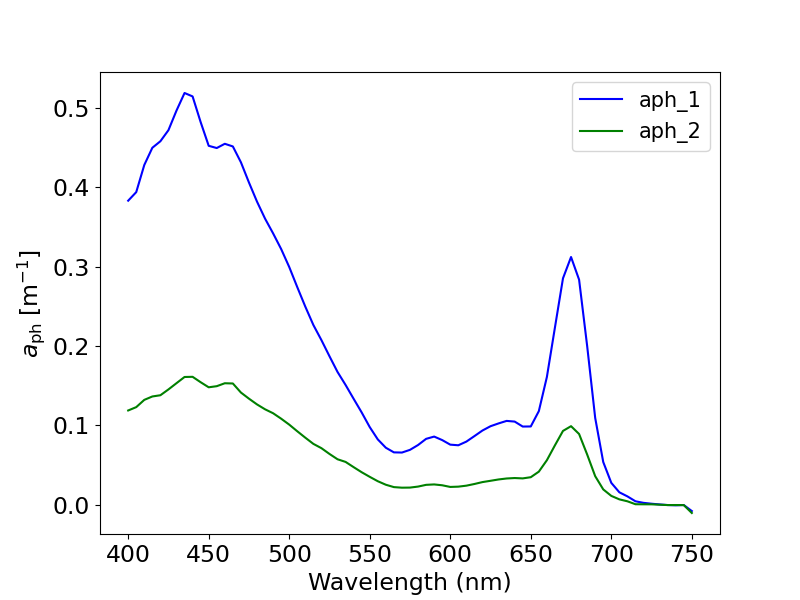

In [23]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()

ax.plot(df_lee.wave, df_lee.aph_1, 'b-', label='aph_1')
ax.plot(df_lee.wave, df_lee.aph_2, 'g-', label='aph_2')
#
ax.set_xlabel(r'Wavelength (nm)')
ax.set_ylabel(r'$a_{\rm ph} \; [\rm m^{-1}]$')
#
ax.legend(fontsize=15.)
oc_plotting.set_fontsize(ax, 17.)
#
#ax.set_xscale('log')
plt.show()

## Whoa, those are pretty extreme!

# Setup

In [24]:
i440 = np.argmin(np.abs(l23_wave-440.))
i600 = np.argmin(np.abs(l23_wave-600.))

# $b_{\rm b,nw}$ histogram at 600nm

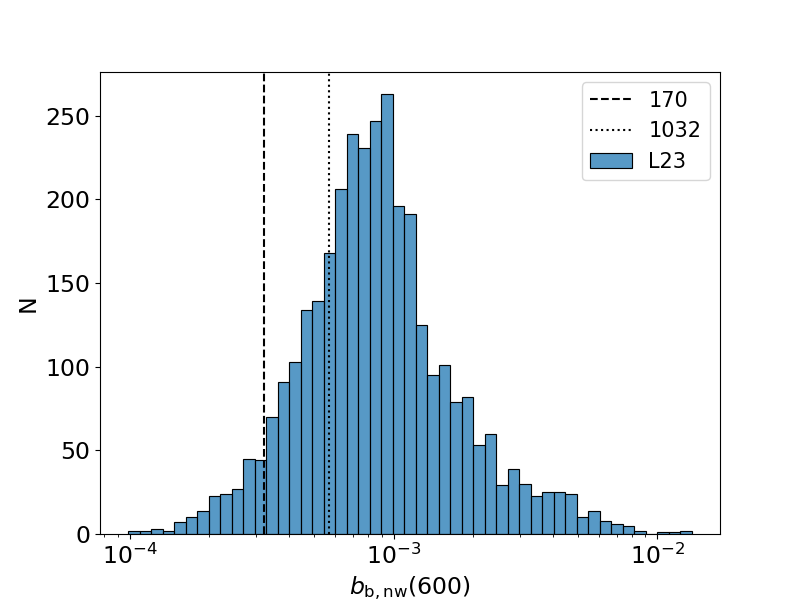

In [25]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()

sns.histplot(all_bbnw[:,i600], log_scale=(True,False), label='L23')
#
ax.set_xlabel(r'$b_{\rm b,nw}(600)$')
ax.set_ylabel('N')
# Mark the two in the paper
ax.axvline(all_bbnw[170,i600], color='k', ls='--', label='170')
ax.axvline(all_bbnw[1032,i600], color='k', ls=':', label='1032')
#
ax.legend(fontsize=15.)
oc_plotting.set_fontsize(ax, 17.)
#
#ax.set_xscale('log')
plt.show()

## So our two examples in the BING paper are below the median but not woefully so

# Let's grab fake $a_{dg}$ and $b_{b,nw}$

## Large values for each

In [26]:
i_bb = np.argmin(np.abs(all_bbnw[:,i600]-0.01))
i_bb

2343

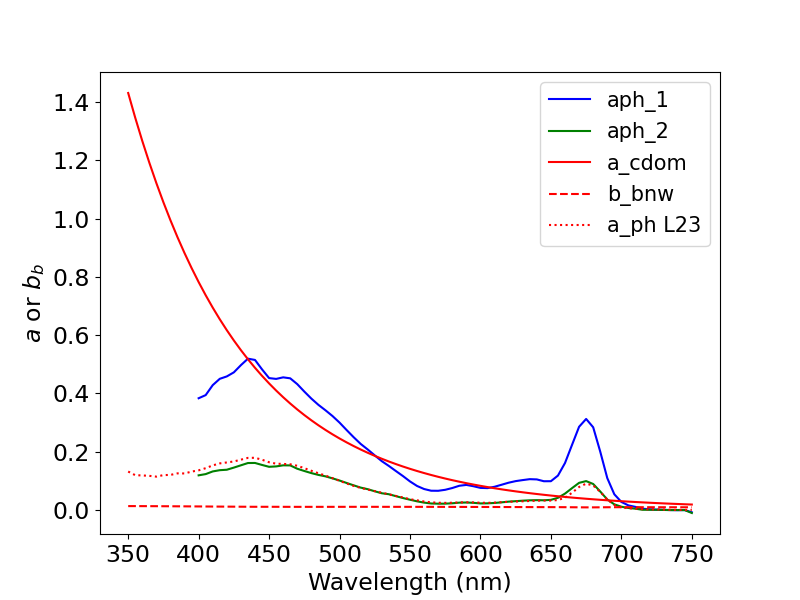

In [29]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()

ax.plot(df_lee.wave, df_lee.aph_1, 'b-', label='aph_1')
ax.plot(df_lee.wave, df_lee.aph_2, 'g-', label='aph_2')
# 
ax.plot(l23_wave, all_adg[i_bb], 'r-', label='a_cdom')
ax.plot(l23_wave, all_bbnw[i_bb], 'r--', label='b_bnw')
ax.plot(l23_wave, all_aph[i_bb], 'r:', label='a_ph L23')
#
ax.set_xlabel(r'Wavelength (nm)')
ax.set_ylabel(r'$a$ or $b_b$')
#
ax.legend(fontsize=15.)
oc_plotting.set_fontsize(ax, 17.)
#
#ax.set_xscale('log')
plt.show()

## Maybe we should scale up for aph_1

# Prep

# Fit